# Exercise 1 - Static Charts with Python

In [656]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics 
from scipy.stats import iqr
import scipy as sci
from plotly.graph_objs import *
import scipy.stats as st
import math
import numbers

In [867]:
# load csv file
#df_confirmed = pd.read_csv('data/time_series_covid_19_confirmed.csv')

df = pd.read_csv('data/COVID19_open_line_list.csv')

In [868]:
df = df.drop(['ID','wuhan(0)_not_wuhan(1)','geo_resolution','lives_in_Wuhan','travel_history_dates','date_onset_symptoms','date_admission_hospital',
                'travel_history_location','reported_market_exposure','additional_information','chronic_disease_binary','age','sex',
                'chronic_disease','sequence_available','outcome','date_death_or_discharge','notes_for_discussion','location','admin3','admin2','admin1',
               'admin_id','data_moderator_initials','Unnamed: 33','Unnamed: 34','Unnamed: 35','Unnamed: 36','Unnamed: 37','Unnamed: 38','Unnamed: 39','Unnamed: 40'
                      ,'Unnamed: 41','Unnamed: 42','Unnamed: 43','Unnamed: 44','source','symptoms','country_new'], axis = 1) 

In [869]:
df = df[(~df.latitude.isna()) & (~df.date_confirmation.isna()) & (~df.city.isna()) & (~df.province.isna()) & (~df.country.isna()) & (df.country == 'China')]

10

In [288]:
def twodkdeplot(date, dataset):
    img = plt.imread('chinamap.png')
    BBox = (dataset.longitude.min()-3,   dataset.longitude.max()+3, dataset.latitude.min()-3, dataset.latitude.max()+3)
    long = dataset.longitude.tolist()
    lat = dataset.latitude.tolist()
    fig, ax = plt.subplots(figsize = (8,7))
    ax = sns.kdeplot(long, lat, cmap="Reds", shade=True, shade_lowest=False, alpha= 0.65, kernel="triw", bw="silverman")
    ax.set_title('Plotting 2d KDE on China Map for '+ date)
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(img, zorder=0, extent = BBox, aspect= 'equal')

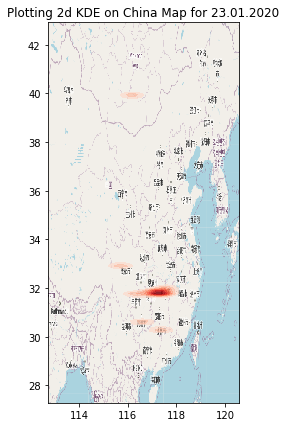

In [808]:
twodkdeplot(givendate,df1)

## Paper implementation

The formula for kernel density width is $h= 0.9 \times min(\sigma, \frac{IQR}{1.34}) \times n^{-\frac{1}{5}}$

In [11]:
#kernel density width
def get_kernel_denstiy_width(dataset_sample):
    sd = statistics.stdev(dataset_sample)
    iqr_val = iqr(dataset_sample, rng=(25,75), interpolation='midpoint')
    n = len(dataset_sample)
    return 0.9*min(sd, (iqr_val/1.34))*n**(-0.2)

The formula for density estimate is $f_{2D}(x,y) = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{h_{s,i}^2}K_s (\frac{x-x_i}{h_{s,i}}, \frac{y-y_i}{h_{s,i}})$ and for triweight kernel is $K_{s,t}(u) = \frac{35}{32} (1-u^2)^3$

$f_{2D}(x,y) = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{h_{s,i}^2}K_s (\frac{x-x_i}{h_{s,i}}) \times K_s( \frac{y-y_i}{h_{s,i}})$

In [1135]:
cubehelix_cs=[[0.0, 'rgba(255, 255, 255, 0)'],
              [0.1, 'rgba(227,242,253, 0.4)'],
              [0.2, 'rgba(187,222,251, 0.7)'],
              [0.3, 'rgba(144,202,249, 0.7)'],
              [0.4, 'rgba(100,181,246, 0.7)'],
              [0.5, 'rgba(66,165,245, 0.7)'],
              [0.6, 'rgba(30,136,229, 0.7)'],
              [0.7, 'rgba(25,118,210, 0.7)'],
              [0.8, 'rgba(21,101,192, 0.7)'],
              [0.9, 'rgba(13,71,161, 0.7)'],
              [1.0, 'rgba(8,50,135, 0.7)']]

In [313]:
def weighted_gaussian_kde(dataset, weights, points):
    d, n = dataset.shape
    
    if weights is not None:
        weights = weights / np.sum(weights)
    else:
        weights = np.ones(n) / n
    
    neff = 1.0 / np.sum(weights ** 2)
    covariance_factor = np.power(neff*(d+2.0)/4.0, -1./(d+4))
        
    #compute covariance
    _mean = np.sum(weights * dataset, axis=1)
    _residual = (dataset - _mean[:, None])
    _data_covariance = np.atleast_2d(np.dot(_residual * weights, _residual.T))
    _data_covariance /= (1 - np.sum(weights ** 2))
    _data_inv_cov = np.linalg.inv(_data_covariance)
    covariance = _data_covariance * covariance_factor**2
    inv_cov = _data_inv_cov / covariance_factor**2
    #Gaussian norm factor
    #_norm_factor = np.sqrt(np.linalg.det(2*np.pi*covariance))
    #Triweight norm factor
    _norm_factor = np.linalg.det(32*covariance/35)
    
    d1, m = points.shape

    result = np.array([0.0] * m)

    whitening = np.linalg.cholesky(inv_cov)
    scaled_dataset = np.dot(whitening, dataset)
    scaled_points = np.dot(whitening, points)

    for i in range(n):
        diff = scaled_dataset[:, i, np.newaxis] - scaled_points
        energy =  np.sum(diff * diff, axis=0) / 2.0
        #Gaussian result
        result += weights[i]*np.exp(-energy)
        #Triweight result
        #result += weights[i]*(1-energy)**3
        
    result = result / _norm_factor
    return result

In [314]:
def kde_scipy( vals1, vals2, a,b, c,d, N, weights = None):

    x=np.linspace(a,b,N)
    y=np.linspace(c,d,N)
    X,Y=np.meshgrid(x,y)
    positions = np.vstack([Y.ravel(), X.ravel()])

    values = np.vstack([vals1, vals2])
    
    kernel = weighted_gaussian_kde(values,weights,positions)
    
    
    Z = np.reshape(kernel.T, X.shape)

    return [x, y, Z]

In [469]:
 def make_kdeplot(varX, varY, a,b, c,d, N, colorsc, title, weights):
    x, y, Z = kde_scipy(varY, varX, a,b, c,d , N, weights)

    data = Data([
       Contour(z=Z, x=x, y=y, colorscale=colorsc, opacity=0.7, contours=Contours(showlines=False)),
     ])

    layout = Layout(
        title= title,
        font= Font(family='Georgia, serif',  color='#635F5D'),
        showlegend=False,
        autosize=False,
        width=650,
        height=650,
        xaxis=XAxis(range=[a,b],showgrid=False,nticks=7),
        yaxis=YAxis(range=[c,d],showgrid=False,nticks=7),
        margin=Margin(l=40,r=40,b=85,t=100,)
    )
    
    fig = Figure(data=data, layout=layout)
    fig.add_layout_image(
        dict(source="chinamap.png", xref="x", yref="y", x=a, y=d, sizex=b-a, sizey=d-c, sizing="stretch", opacity=1.0, layer="below")
    )

    return fig, Z, x, y


In [1231]:
givendate = '24.01.2020'
df1 = df[df.date_confirmation == givendate]
df1 = df1.iloc[0:20]
x=df1['longitude'].tolist()
y=df1['latitude'].tolist()

x_min=min(df.longitude.tolist())
x_max=max(df.longitude.tolist())
y_min=min(df.latitude.tolist())
y_max=max(df.latitude.tolist())


N=len(x)
fig, Z, xi, yi = make_kdeplot(x, y, x_min, x_max, y_min, y_max,
             N, cubehelix_cs,'Covid-19 in China on: ' + givendate, None)
fig

In [1088]:
xi

array([ 82.0969,  87.7024,  93.3079,  98.9134, 104.5189, 110.1244,
       115.7299, 121.3354, 126.9409, 132.5464])

In [519]:
def create_df_from_Z_and_coords(xi, yi, Z):
    data = {}
    data['x'] = xi.tolist()
    for i in range(0,len(yi)):
        yistr = str(yi[i])
        data[yistr] = Z[i].tolist()
    return pd.DataFrame (data)

In [905]:
def get_k_highest_values(k, x_1, y_1, Z_1):
    data = []
    for i in range(0,len(x_1)):
        for j in range(0, len(y_1)):
            row = [x_1[i], y_1[j], Z_1[j][i]]
            data.append(row)
    sdi = np.transpose(data)
    idx = np.argpartition(sdi[2], -k)
    kdeval = sdi[2][idx[-k:]]
    xval = sdi[0][idx[-k:]]
    yval = sdi[1][idx[-k:]]
    return xval, yval, kdeval


In [1177]:

df_1 = df[df.date_confirmation == '25.01.2020']
df_1 = df_1.iloc[0:10]
x_1, y_1 , Z_1 = get_2dkde(df_1)

hx_1, hy_1, hZ_1 = get_k_highest_values(15, x_1, y_1, Z_1)


df0 = df[df.date_confirmation == '26.01.2020']
df0 = df0.iloc[0:10]
x0, y0 , Z0 = get_2dkde(df0)
nz = len(Z0) * len(Z0[0])

hx0, hy0, hZ0 = get_k_highest_values(nz, x0, y0, Z0)


In [1128]:
#Me hek sum me kthy antarin me vleren e res ma tmadhe mas miri nashta
def compare(long, lat, zval, x0, y0, z0, k=1, a0 =1, a1=1):
    retval = []
    for i in range(0, len(x0)):
        dist = euclidean_distance(long,x0[i],lat,y0[i])
        if dist != 0:
            res = (zval**a0) * (z0[i]**a1) / dist
            retval.append([x0[i], y0[i], res])
    sdi = np.transpose(retval)
    idx = np.argpartition(sdi[2], -1)
    sdi[2][idx[-1:]]
    return [sdi[0][idx[-1:]][0], sdi[1][idx[-1:]][0], sdi[2][idx[-1:]][0]]
            

In [1068]:
#Me gjet antarin ma te afert nashta mas miri
def compare(long, lat, zval, x0, y0, z0, k=1, a0 =1, a1=1):
    retval = []
    for i in range(0, len(x0)):
        dist = euclidean_distance(long,x0[i],lat,y0[i])
        if dist != 0:
            res = (zval**a0) * (z0[i]**a1) / dist
            retval.append([x0[i], y0[i], res])
    sdi = np.transpose(retval)
    idx = np.argpartition(sdi[2], -1)
    sdi[2][idx[-1:]]
    return [sdi[0][idx[-1:]][0], sdi[1][idx[-1:]][0], sdi[2][idx[-1:]][0]]

In [1094]:
# comparetest(117.36093333333334, 32.42789444444445, 0.010087486739655, hx0, hy0, hZ0)

In [1178]:
data = []
for i in range(0,len(hx_1)):
    compval = compare(hx_1[i], hy_1[i], hZ_1[i], hx0, hy0, hZ0)
    data.append([hx_1[i], hy_1[i], compval])

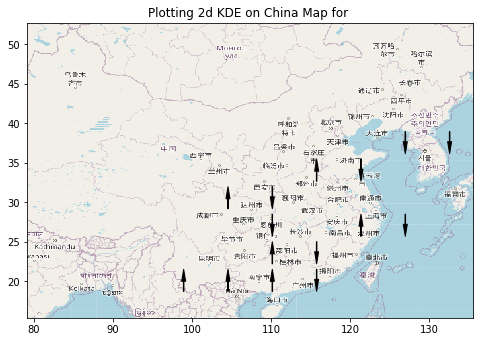

In [1187]:
img = plt.imread('chinamap.png')
BBox = (df.longitude.min()-3,   df.longitude.max()+3, df.latitude.min()-3, df.latitude.max()+3)
fig, ax = plt.subplots(figsize = (8,7))
ax.set_title('Plotting 2d KDE on China Map for ')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(img, zorder=0, extent = BBox, aspect= 'equal')
arrow_properties = dict(facecolor="black", width=0.5,headwidth=4, shrink=0.1)
for i in range(0, len(data)):
    ax.annotate("", xy=(data[i][2][0], data[i][2][1]),xytext=(data[i][0], data[i][1]), arrowprops=arrow_properties)

In [156]:
def euclidean_distance(long1,long2,lat1,lat2):
    x = (long1,lat1)
    y = (long2,lat2)
    distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))
    return distance


In [516]:
def maca(dataframe):
    n = len(dataframe)
    matrix = []
    for i in range(0,n):
        rows = []
        for j in range(0,n):
            dist = euclidean_distance(dataframe.iloc[i].longitude, dataframe.iloc[j].longitude, dataframe.iloc[i].latitude, dataframe.iloc[j].latitude)
            rows.append(dist)
        matrix.append(rows)
    
    return matrix

In [1125]:
def get_2dkde(dataset):
    x=dataset['longitude'].tolist()
    y=dataset['latitude'].tolist()
    x, y, Z = kde_scipy(y, x, min(df.longitude.tolist()),max(df.longitude.tolist()), min(df.latitude.tolist()), 
                        max(df.latitude.tolist()),len(x), None)
    return x,y, Z
    
    
def testfunc(t_1,t0):
    df_1 = df[df.date_confirmation == t_1]
    df_1 = df_1.iloc[0:10]
    x_1, y_1, Z_1 = get_2dkde(df_1)
    df_1_coords = [x_1.tolist(), y_1.tolist()]
    
    df0 = df[df.date_confirmation == t0]
    df0 = df0.iloc[0:10]
    x0, y0, Z0 = get_2dkde(df0)
    df0_coords = [x0.tolist(), y0.tolist()]
    
    
    return [Z_1, Z0], [df_1_coords,df0_coords]

In [814]:
def get_2dkde_dataframes(t_1,t0):
    df_1 = df[df.date_confirmation == t_1]
    df_1 = df_1.iloc[0:10]
    x_1, y_1 , Z_1 = get_2dkde(df_1)
    res_1 = create_df_from_Z_and_coords(x_1, y_1, Z_1)
    res_1['date'] = t_1
    
    df0 = df[df.date_confirmation == t0]
    df0 = df0.iloc[0:10]
    x0, y0 , Z0 = get_2dkde(df0)
    res0 = create_df_from_Z_and_coords(x0, y0, Z0)
    res0['date'] = t0
    
    return res_1, res0

In [815]:
df_1, df0 = get_2dkde_dataframes('23.01.2020','24.01.2020')

In [843]:

latitudes = df_1.columns.tolist()
latitudes.remove('x')
latitudes.remove('date')




In [782]:
lo = 116.615
la = 31.58116
longitudes = df0.x.tolist()
latitudes = df0.columns.tolist()
latitudes.remove('x')
latitudes.remove('date')

valuelist = []
for i in range(0,len(longitudes)):
    for j in range(0, len(latitudes)):
        dist = euclidean_distance(lo,longitudes[i],la,float(latitudes[j]))
        coord_dist = [longitudes[i], float(latitudes[j]), dist]
        valuelist.append(coord_dist)


In [776]:
sdi = np.transpose(valuelist)
idx = np.argpartition(sdi[2], 5)
sdi[0][idx[:5]]

array([116.3151, 116.3151, 116.3151, 116.3151, 116.3151])

In [775]:
# x = longitude
# y = latitude

maca - (1,2,3)

array([30.66323222, 30.93727667, 31.75941   , 31.21132111, 31.48536556])

In [728]:
def fmap3d(W,T, x, y, t, zvalues, coords,a0=1,a1=1):
    res = 0    
    for i in range(x-W,x+W):
        if ((i < 0) or (i >= len(zvalues[0]))):
            continue
        for j in range(y-W, y+W):
            if ((j < 0) or (j >= len(zvalues[0]))):
                continue
            for k in range(t-T,t+T):
                if ((k < 0) or (k >= len(zvalues))):
                    continue
                #Mujm me lujt me fuqi a0 edhe a1, duhet me llogarit distancen
                
                dist = euclidean_distance(coords[t][0][x], coords[k][0][i], coords[t][1][x], coords[k][1][i])
                
                if dist != 0:
                    res += (zvalues[t][x][y]**a0) * (zvalues[k][i][j]**a1) / dist
    return res


                
def famp_all(W):
    values, cords = testfunc('23.01.2020','24.01.2020')
    n = len(values[0])
    t = len(values)
    
    result = [ [ [ 0 for x in range(n) ] for y in range(n) ] for k in range( t ) ]
    for k in range(0,t):
        for i in range(0,n):
            for j in range (0,n):
                result[k][i][j] = fmap3d(W, t, i, j, k, values, cords)
    return result, cords
                
            
            
            

In [1257]:
df_1 = df[df.date_confirmation == '24.01.2020']
df_1 = df_1.iloc[0:20]
x_1, y_1 , Z_1 = get_2dkde(df_1)

hx_1, hy_1, hZ_1 = get_k_highest_values(50, x_1, y_1, Z_1)


df0 = df[df.date_confirmation == '25.01.2020']
df0 = df0.iloc[0:20]
x0, y0 , Z0 = get_2dkde(df0)
nz = len(Z0) * len(Z0[0])
hx0, hy0, hZ0 = get_k_highest_values(nz, x0, y0, Z0)

In [1244]:
def compare2(long, lat, zval, x0, y0, z0, k=1, a0 =1, a1=1):
    retval = []
    for i in range(0, len(x0)):
        dist = euclidean_distance(long,x0[i],lat,y0[i])
        if dist != 0:
            if (dist > 5) & (dist < 7 ):
                res = (zval**a0) * (z0[i]**a1) / dist
                retval.append([x0[i], y0[i], z0[i]])
    sdi = np.transpose(retval)
    idx = np.argpartition(sdi[2], -1)
    sdi[2][idx[-1:]]
    return [sdi[0][idx[-1:]][0], sdi[1][idx[-1:]][0], sdi[2][idx[-1:]][0]]

In [1258]:
data = []
for i in range(0,len(hx_1)):
    compval = compare2(hx_1[i], hy_1[i], hZ_1[i], hx0, hy0, hZ0)
    data.append([hx_1[i], hy_1[i], compval])
    
data

[[116.61497894736843,
  34.87874,
  [121.92545263157896, 36.52753, 0.00010631841464937796]],
 [127.23592631578947,
  33.22995,
  [121.92545263157896, 36.52753, 0.00010631841464937796]],
 [119.2702157894737,
  34.87874,
  [113.95974210526316, 31.58116, 0.0094338745556829]],
 [98.02832105263158,
  31.58116,
  [103.33879473684212, 28.28358, 4.0410179110832704e-42]],
 [98.02832105263158,
  26.634790000000002,
  [103.33879473684212, 24.986, 9.409761008186038e-26]],
 [103.33879473684212,
  26.634790000000002,
  [108.64926842105264, 28.28358, 1.3522923149628938e-10]],
 [95.37308421052632,
  28.28358,
  [100.68355789473685, 24.986, 1.0254138426393704e-35]],
 [100.68355789473685,
  31.58116,
  [105.99403157894737, 28.28358, 2.6820409243810856e-18]],
 [119.2702157894737,
  29.93237,
  [116.61497894736843, 24.986, 0.23060432278373086]],
 [103.33879473684212,
  33.22995,
  [108.64926842105264, 29.93237, 2.480540581149979e-12]],
 [100.68355789473685,
  26.634790000000002,
  [105.99403157894737, 26.

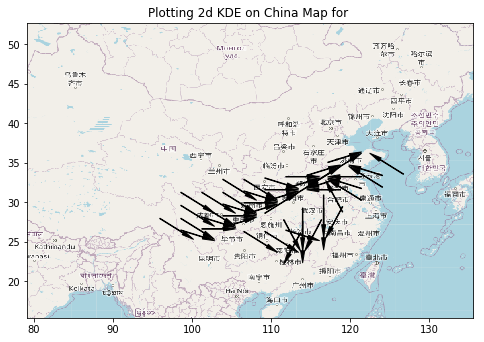

In [1259]:
img = plt.imread('chinamap.png')
BBox = (df.longitude.min()-3,   df.longitude.max()+3, df.latitude.min()-3, df.latitude.max()+3)
fig, ax = plt.subplots(figsize = (8,7))
ax.set_title('Plotting 2d KDE on China Map for ')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(img, zorder=0, extent = BBox, aspect= 'equal')
arrow_properties = dict(facecolor="black", width=0.5,headwidth=4, shrink=0.1)
for i in range(0, len(data)):
    ax.annotate("", xy=(data[i][2][0], data[i][2][1]),xytext=(data[i][0], data[i][1]), arrowprops=arrow_properties)